**DATA CLEANING**

In [1]:
#1.Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
#2.Load data
url = "https://raw.githubusercontent.com/Sabriyana/JobPostings-EDA-Task/main/jobpostings.csv"
df = pd.read_csv(url)


print("Initial Shape:", df.shape)
df.head()

Initial Shape: (37793, 14)


,Country,Role,Job_Title,Company,Location,Salary_Min,Salary_Max,Salary_Currency,Created_Date,Description,Experience_Years,Skills,URL,Timestamp
0,AU,AI Engineer,AI Engineer,Epworth,"Richmond, Yarra Area",NaN,NaN,NaN,2025-11-14T22:37:52Z,Job Description The AI Engineer is a key membe...,NaN,research,https://www.adzuna.com.au/details/5495521263?u...,2025-11-29
1,AU,AI Engineer,AI Engineer,Fivecast,"Adelaide, Adelaide Region",NaN,NaN,NaN,2025-11-06T07:27:09Z,About the Role We're looking to hire an AI Eng...,NaN,NaN,https://www.adzuna.com.au/details/5482725750?u...,2025-11-29
2,AU,AI Engineer,AI Engineer,Zone IT Solutions,"The Rocks, Sydney",80000.0,180000.0,NaN,2025-09-04T15:28:32Z,We are seeking an experienced AI Full Stack En...,4.0,python,https://www.adzuna.com.au/details/5382585885?u...,2025-11-29
3,AU,AI Engineer,AI Engineer,Professional Search Group,"Perth CBD, Perth",NaN,NaN,NaN,2025-10-03T03:35:30Z,Job Description Job Title: AI Engineer Locatio...,NaN,NaN,https://www.adzuna.com.au/details/5427272851?u...,2025-11-29
4,AU,AI Engineer,AI Engineer,GHD,"Brisbane CBD, Brisbane",NaN,NaN,NaN,2025-08-12T20:58:16Z,"Description At GHD, we don’t just believe in t...",NaN,NaN,https://www.adzuna.com.au/details/5348919138?u...,2025-11-29


In [3]:
print(df.isnull().sum())

Country                 0
Role                    0
Job_Title               0
Company               979
Location                0
Salary_Min          25650
Salary_Max          25671
Salary_Currency     37793
Created_Date            0
Description             0
Experience_Years    34798
Skills              25350
URL                     0
Timestamp               0
dtype: int64


In [4]:
#3.Missing value handling
string_cols = ['Company', 'Skills', 'Salary_Currency']
df[string_cols] = df[string_cols].fillna("Not Provided")

In [5]:
# Convert Created_Date to datetime
df['Created_Date'] = pd.to_datetime(df['Created_Date'], errors='coerce')

In [6]:
#Feature Engineering
df['Year'] = df['Created_Date'].dt.year
df['Month'] = df['Created_Date'].dt.month
df['Quarter'] = df['Created_Date'].dt.quarter

def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    if month in [3, 4, 5]: return "Spring"
    if month in [6, 7, 8]: return "Summer"
    if month in [9, 10, 11]: return "Autumn"
    return "Not Provided"

df['Season'] = df['Month'].apply(lambda m: get_season(m) if pd.notnull(m) else 'Not Provided')

In [7]:
df['Experience_Years'] = pd.to_numeric(df['Experience_Years'], errors='coerce')

def categorize_experience(x):
    if pd.isna(x): return "Not Provided"
    if x < 3: return "Junior"
    if x <= 7: return "Mid"
    return "Senior"

df['Experience_Level'] = df['Experience_Years'].apply(categorize_experience)

In [8]:
#Outlier removal and cleaning
df['Salary_Min'] = pd.to_numeric(df['Salary_Min'], errors='coerce')
df['Salary_Max'] = pd.to_numeric(df['Salary_Max'], errors='coerce')

salary_df = df[(df['Salary_Min'].notna()) & (df['Salary_Max'].notna())].copy()
salary_df['Salary_Avg'] = salary_df[['Salary_Min', 'Salary_Max']].mean(axis=1)

Q1 = salary_df['Salary_Avg'].quantile(0.25)
Q3 = salary_df['Salary_Avg'].quantile(0.75)
IQR = Q3 - Q1

salary_df = salary_df[
    (salary_df['Salary_Avg'] >= Q1 - 1.5 * IQR) &
    (salary_df['Salary_Avg'] <= Q3 + 1.5 * IQR)
]

print("\nClean Salary Data Shape:", salary_df.shape)



Clean Salary Data Shape: (10836, 20)


In [9]:
df = df.drop(columns=['Experience_Years', 'Salary_Currency', 'URL', 'Timestamp', 'Created_Date'])

In [10]:
#Color Palette
base_purple = "#8502f7"
palette = sns.light_palette(base_purple, n_colors=10, reverse=True, input="hex")
sns.set_palette(palette)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)

**VISUALIZATIONS**

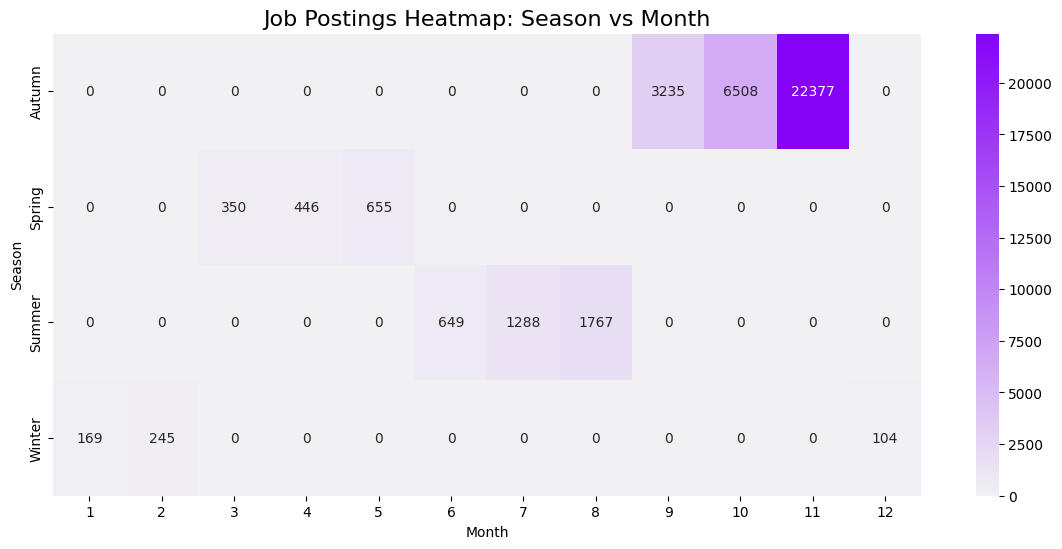

In [11]:
#Heatmap: Season vs Month
pivot_table = df.pivot_table(index='Season', columns='Month', values='Role', aggfunc='count').fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap=sns.light_palette(base_purple, as_cmap=True))
plt.title("Job Postings Heatmap: Season vs Month", fontsize=16)
plt.show()


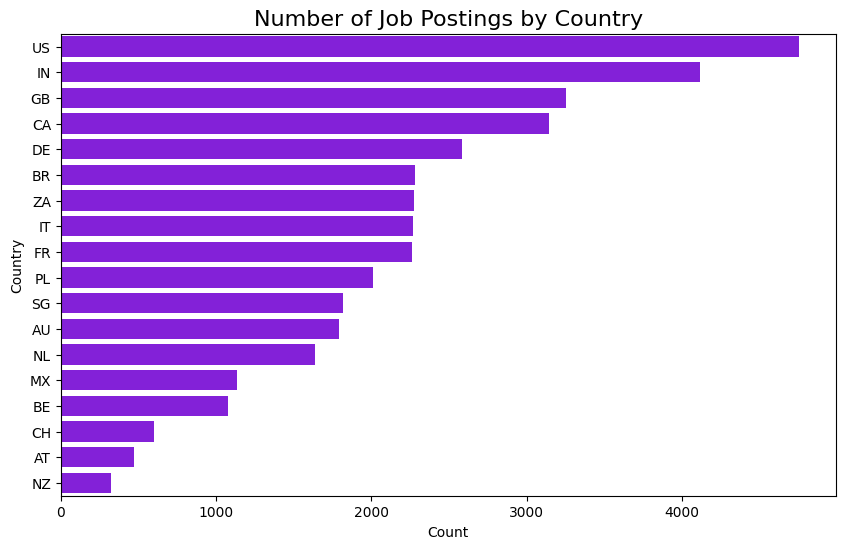

In [12]:
#Bar Chart: Job Postings by Country
country_counts = df['Country'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title("Number of Job Postings by Country", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()

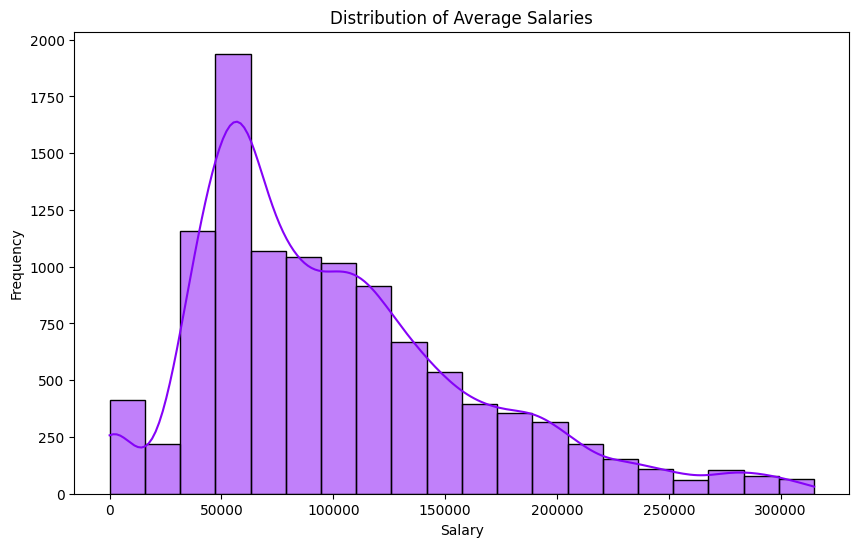

In [13]:
#Histogram: Salary Distribution
plt.figure(figsize=(10, 6))
sns.histplot(salary_df['Salary_Avg'], bins=20, kde=True)
plt.title("Distribution of Average Salaries")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.show()

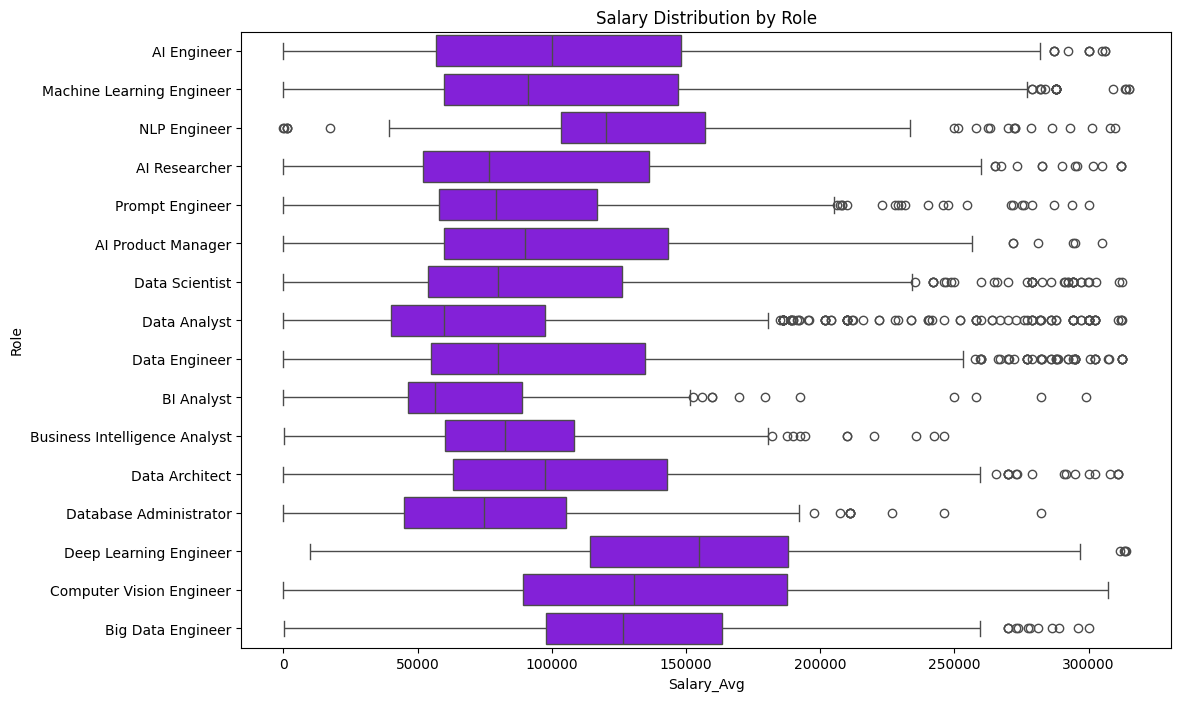

In [14]:
#Boxplot: Salary by Role
plt.figure(figsize=(12, 8))
sns.boxplot(data=salary_df, x='Salary_Avg', y='Role')
plt.title("Salary Distribution by Role")
plt.show()

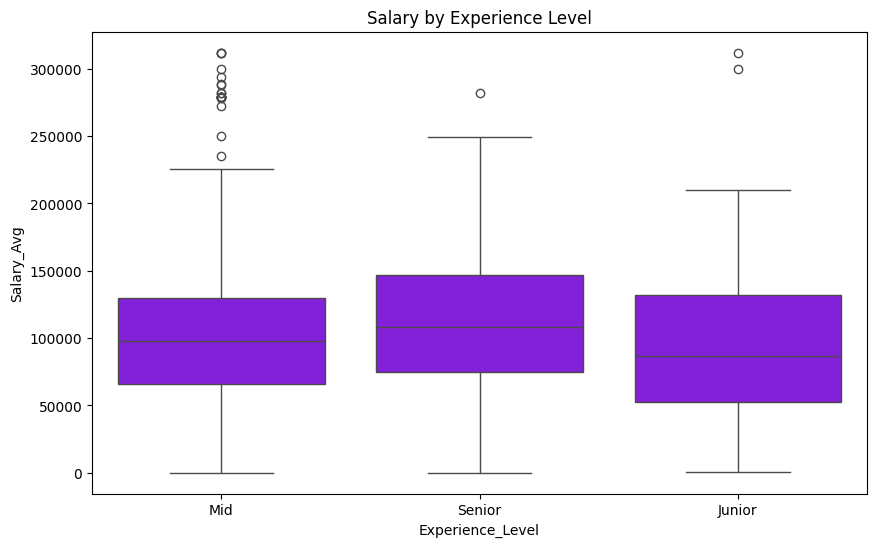

In [15]:
#Boxplot: Salary by Experience Level
exp_df = salary_df[salary_df['Experience_Level'] != "Not Provided"]

plt.figure(figsize=(10, 6))
sns.boxplot(data=exp_df, x='Experience_Level', y='Salary_Avg')
plt.title("Salary by Experience Level")
plt.show()

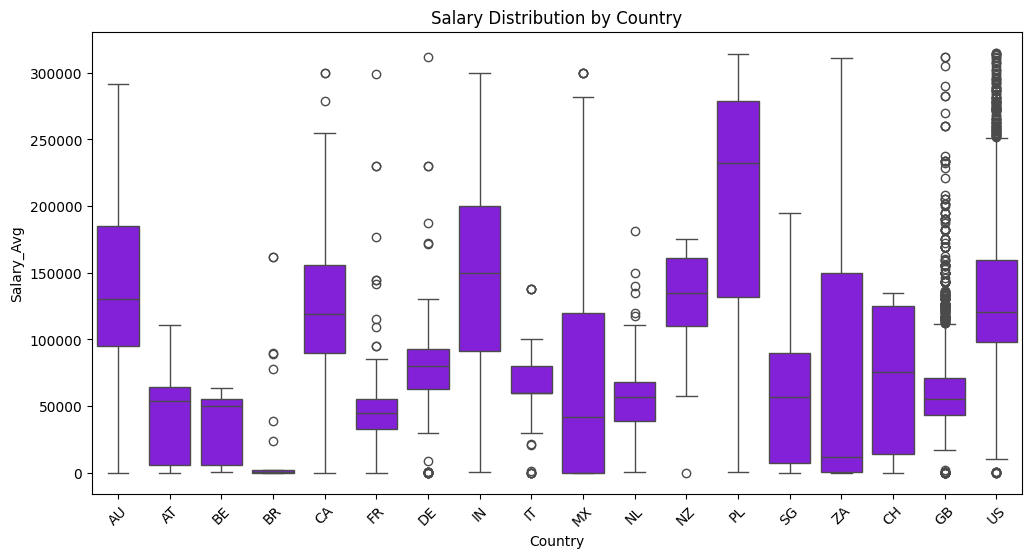

In [16]:
#Boxplot: Salary by Country
plt.figure(figsize=(12, 6))
sns.boxplot(data=salary_df, x='Country', y='Salary_Avg')
plt.xticks(rotation=45)
plt.title("Salary Distribution by Country")
plt.show()

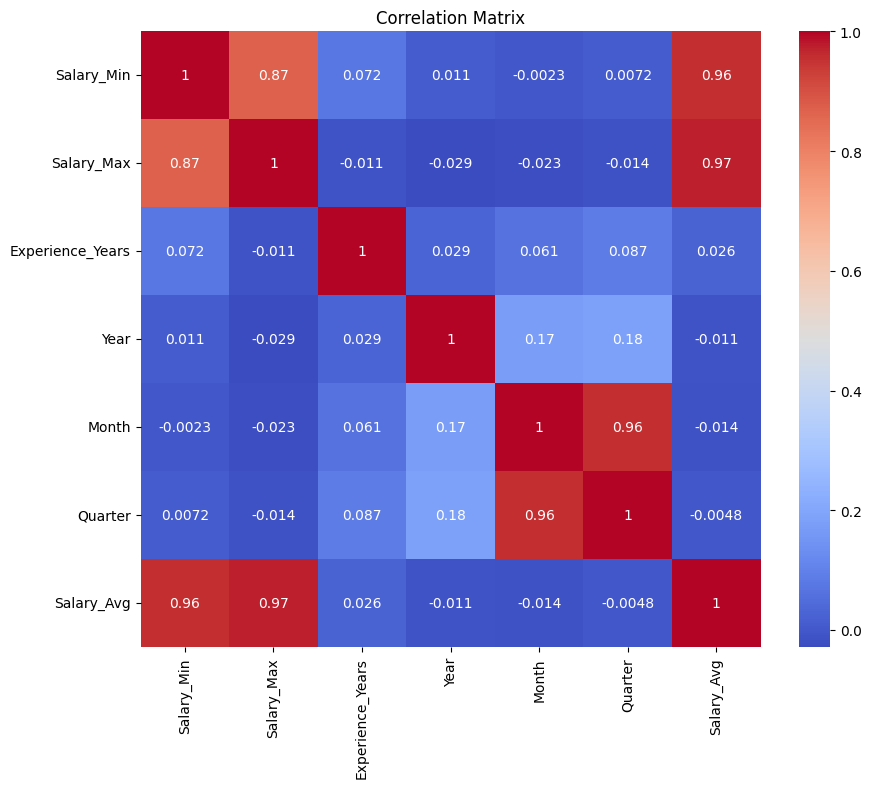

In [17]:
#Correlation Matrix
numeric_cols = salary_df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(10, 8))
sns.heatmap(salary_df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

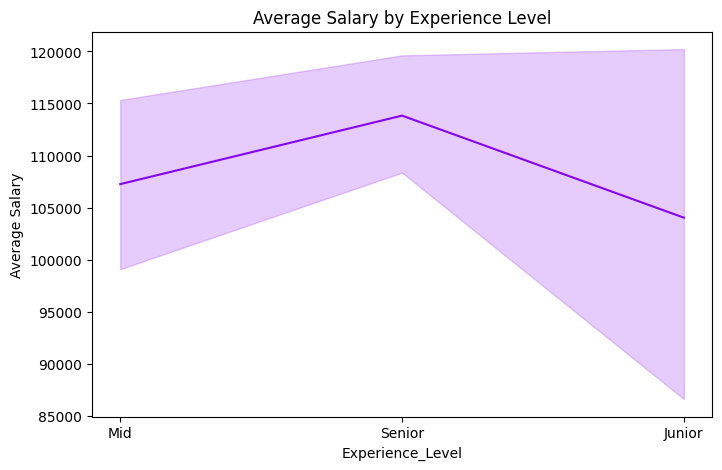

In [18]:
plt.figure(figsize=(8,5))
sns.lineplot(
    data=exp_df,
    x='Experience_Level',
    y='Salary_Avg',
    estimator='mean'
)
plt.title("Average Salary by Experience Level")
plt.ylabel("Average Salary")
plt.show()

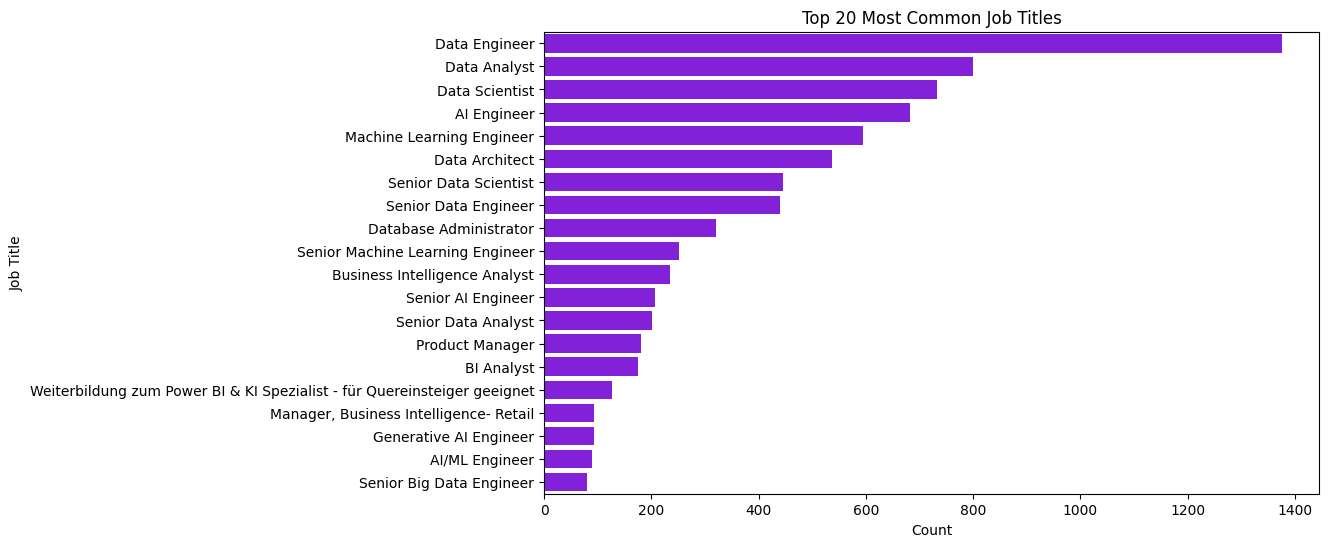

In [19]:
top_titles = df['Job_Title'].value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_titles.values, y=top_titles.index)
plt.title("Top 20 Most Common Job Titles")
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.show()

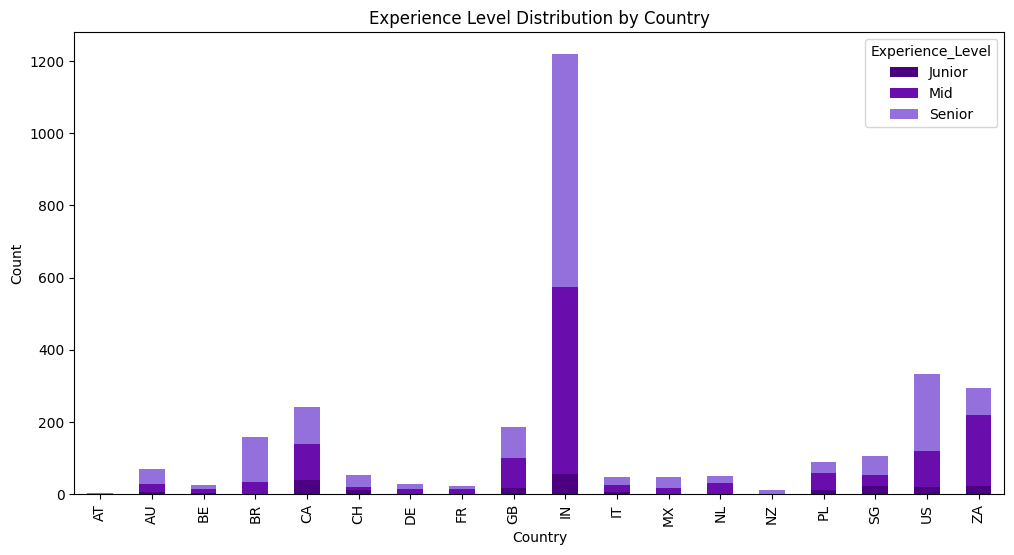

In [20]:
exp_clean = df[df['Experience_Level'] != "Not Provided"]
exp_country = pd.crosstab(exp_clean['Country'], exp_clean['Experience_Level'])
colors = ['#4b0082', '#6a0dad', '#9370db', '#d8bfd8']  # from dark to light purple
exp_country.plot(kind='bar', stacked=True, figsize=(12,6), color=colors)
plt.title("Experience Level Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

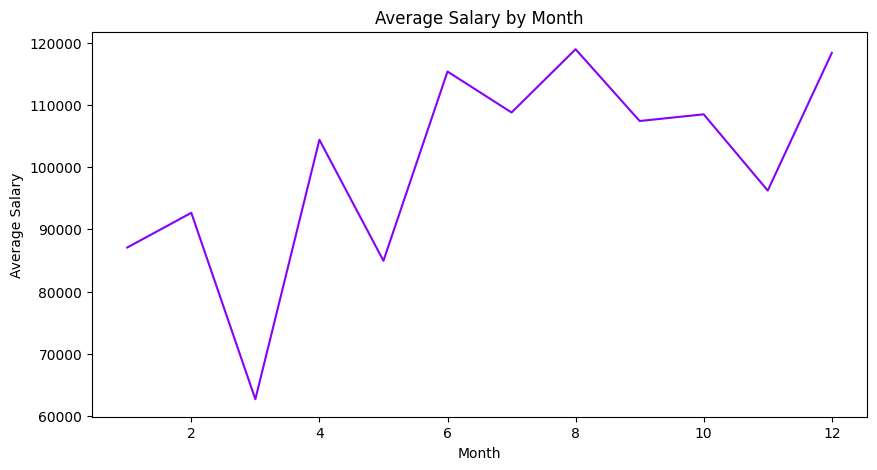

In [21]:
monthly_salary = salary_df.groupby('Month')['Salary_Avg'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_salary.index, y=monthly_salary.values)
plt.title("Average Salary by Month")
plt.xlabel("Month")
plt.ylabel("Average Salary")
plt.show()

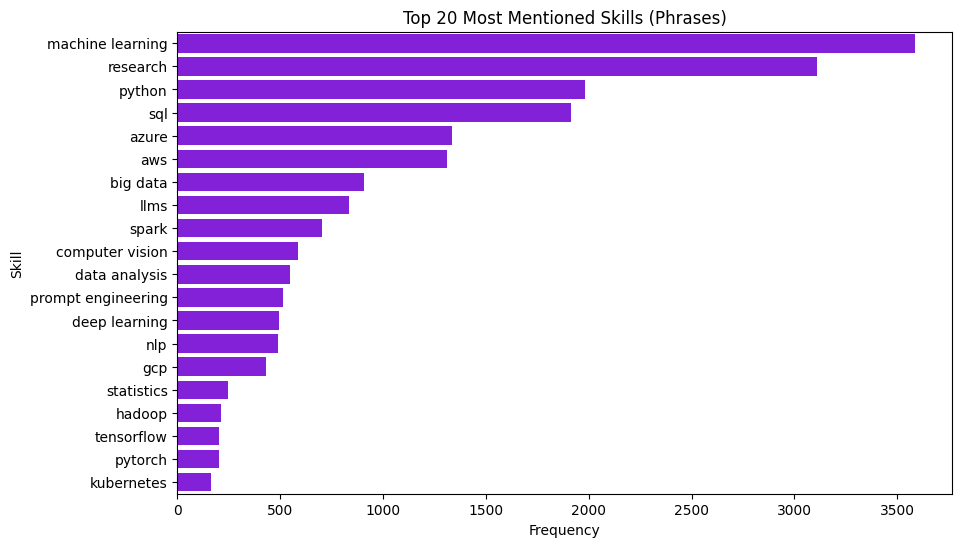

In [22]:
skills_clean = df[df['Skills'].notna() & (df['Skills'] != "Not Provided")]
skills_list = (
    skills_clean['Skills']
    .astype(str)
    .apply(lambda x: re.split(r',|;|/|\|', x))
    .explode()
)

skills_list = skills_list.str.strip().str.lower()
skills_list = skills_list[skills_list != ""]
top_skills = skills_list.value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_skills.values, y=top_skills.index)
plt.title("Top 20 Most Mentioned Skills (Phrases)")
plt.xlabel("Frequency")
plt.ylabel("Skill")
plt.show()


In [23]:
print("Last Shape:", df.shape)
df.head()

Last Shape: (37793, 14)


,Country,Role,Job_Title,Company,Location,Salary_Min,Salary_Max,Description,Skills,Year,Month,Quarter,Season,Experience_Level
0,AU,AI Engineer,AI Engineer,Epworth,"Richmond, Yarra Area",NaN,NaN,Job Description The AI Engineer is a key membe...,research,2025,11,4,Autumn,Not Provided
1,AU,AI Engineer,AI Engineer,Fivecast,"Adelaide, Adelaide Region",NaN,NaN,About the Role We're looking to hire an AI Eng...,Not Provided,2025,11,4,Autumn,Not Provided
2,AU,AI Engineer,AI Engineer,Zone IT Solutions,"The Rocks, Sydney",80000.0,180000.0,We are seeking an experienced AI Full Stack En...,python,2025,9,3,Autumn,Mid
3,AU,AI Engineer,AI Engineer,Professional Search Group,"Perth CBD, Perth",NaN,NaN,Job Description Job Title: AI Engineer Locatio...,Not Provided,2025,10,4,Autumn,Not Provided
4,AU,AI Engineer,AI Engineer,GHD,"Brisbane CBD, Brisbane",NaN,NaN,"Description At GHD, we don’t just believe in t...",Not Provided,2025,8,3,Summer,Not Provided
